<a href="https://colab.research.google.com/github/randy-tsukemen/Data_science_roadmap/blob/master/pca_eigen_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Eigen-portfolio construction using Principal Component Analysis (PCA)

### PCA via sklearn.decomposition using S&P 500 Index stock data

We look in-depth at model-free factor analysis using PCA. By model-free we mean that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using Principal Component Analysis (PCA) to deduce structure of portfolio returns.

We work with S&P 500 index stock data. 

In [17]:
import os
import os.path
import numpy as np
import datetime
import seaborn as sns
sns.set()

import sys
sys.path.append("..")

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

  pandas: 1.0.5


In [4]:
# load dataset
asset_prices = pd.read_csv('https://gist.githubusercontent.com/fqx/e18d22cbf461739cd3b546bdd00773f0/raw/af57b688c54a6720bae5c1bc3ad220e1ceccec18/spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [5]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


#### Asset Returns Calculation

- Calculate percent returns, also known as simple returns using asse_prices. assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

- Calculate de-meaned returns and scale them by standard deviation $\sigma$. 

We now compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [7]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)
normed_returns = asset_returns
# normed_returns is pandas.DataFrame that should contain normalized returns
asset_returns = asset_prices.pct_change().dropna()
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()


normed_returns.iloc[-5:, -10:].head()

,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2013-12-16,0.852722,0.965219,-1.168885,0.884751,0.095865,0.656639,0.180014,-0.238498,0.465047,0.467931
2013-12-17,0.275173,0.517307,-0.086106,-0.306213,0.589689,-0.118610,-0.549523,0.025268,-0.260013,-0.247921
2013-12-18,0.864485,0.509435,0.600714,1.210605,-0.190024,0.925461,0.756998,0.058428,0.952458,1.252703
2013-12-19,0.210069,0.399574,-0.100159,-0.757419,-0.208023,0.304913,-0.772205,1.544228,-0.167775,-0.056358
2013-12-20,0.827306,0.748420,0.372443,1.048113,0.264046,0.436874,0.320641,-0.740854,0.373717,0.353859


In [8]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 419)
Test dataset: (437, 419)


Now we compute PCA using all available data. Once we do have PCA computed we fix variance explained at some number and see what is the smallest number of components needed to explain this variance.

PCA fitting

- Calculate covariance matrix using training data set, i.e. **df_train** for all assets.  Assign results to **cov_matrix**.
- Calculate covariance matrix using training data set, i.e. **df_raw_train** for all assets.  Assign results to **cov_matrix_raw**.
- Use scikit-learn PCA to fit PCA model to **cov_matrix**. Assign fitted model to **pca**

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

stock_tickers = normed_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]
    assert 'SPX' not in stock_tickers, "By accident included SPX index"

    cov_matrix = df_train.loc[:, df_train.columns != 'SPX'].cov()    
    # computing PCA on S&P 500 stocks
    pca = PCA().fit(cov_matrix)
    # not normed covariance matrix
    cov_matrix_raw = df_raw_train.loc[:, df_raw_train.columns != 'SPX'].cov()  
    
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


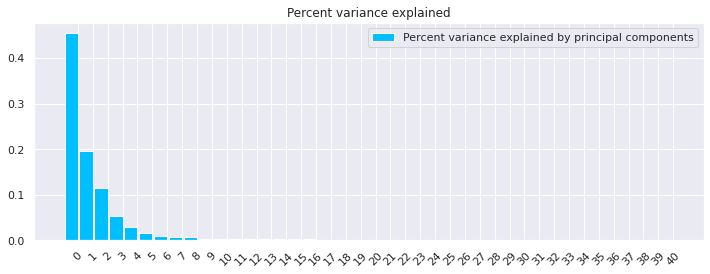

In [18]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

In [12]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

#### Eigen-portfolios construction

We now look a the first two eigen portfolios. We use definition of eigen portfolios as provided by Avellaneda 
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Following Avellaneda we define eigen portfolio weights as:
$$Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i}$$

where $j$ is the index of eigen portfolio and $v_i$ is the i-th element of j-th eigen vector.

In the code the pca.components_ are the Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.


Assign **pc_w** to be weights of the first eigen portfolio.

Sum of weights of first eigen-portfolio: 100.00


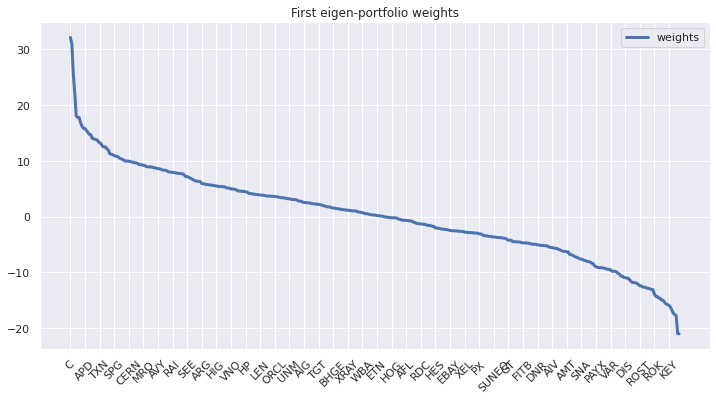

In [19]:
# the first two eigen-portfolio weights# the fi 
# first component
# get the Principal components
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
if pca is not None:
    pcs = pca.components_

    # normalized to 1 
    pc_w = pcs[:, 0] / sum(pcs[:, 0])
        
    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

We sort the first two eigen portfolio weights and plot the results.

Sum of weights of second eigen-portfolio: 100.00


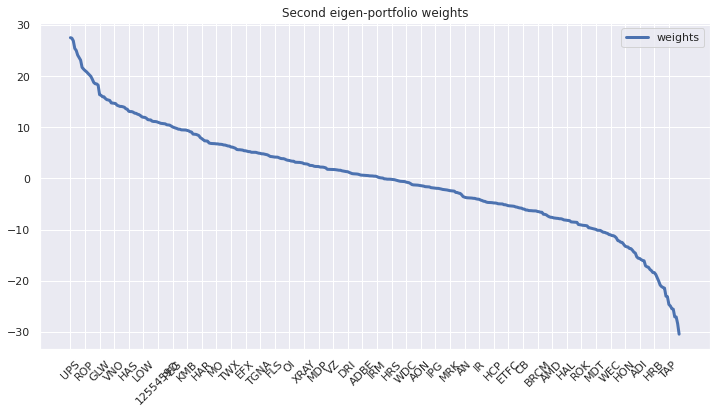

In [20]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_
    
    # normalized to 1 
    pc_w = pcs[:, 1] / sum(pcs[:, 1])

    eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

#### Compute performance of several eigen portfolios

- The function sharpe_ratio() takes ts_returns argument of type pd.Series and returns a tuple of annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility 
- Check portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [21]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.

    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns),(1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.

First eigen-portfolio:
Return = 41.39%
Volatility = 31.50%
Sharpe = 1.31


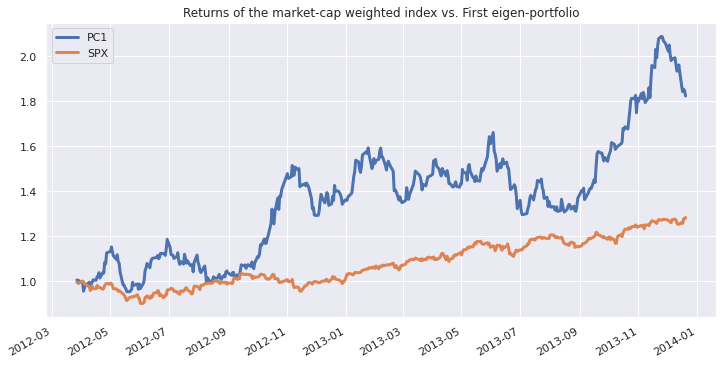

In [22]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

In [23]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))

Second eigen-portfolio:
Return = 15.76%
Volatility = 42.84%
Sharpe = 0.37


We repeat the procedure of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


Eigen portfolio #42 with the highest Sharpe. Return 61.14%, vol = 22.80%, Sharpe = 2.68


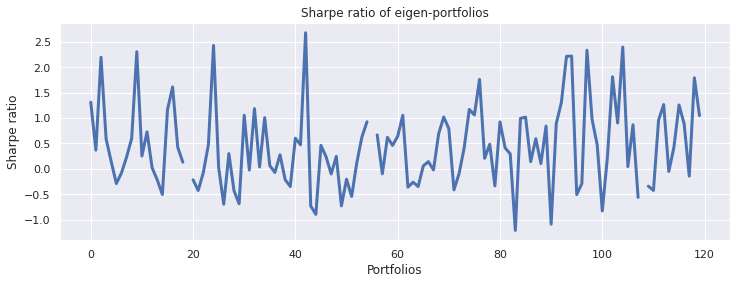

In [24]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
        
        pc_w = pcs[:, ix] / sum(pcs[:, ix])
        eigen_prtfix = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfix.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prtix_returns = np.dot(df_raw_test.loc[:, eigen_prtfix.index], eigen_prtfix / 100)
        eigen_prtix_returns = pd.Series(eigen_prtix_returns.squeeze(), index=df_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prtix_returns)
        annualized_ret[ix] = er
        annualized_vol[ix] = vol
        sharpe_metric[ix] = sharpe
    
    
    
    # find portfolio with the highest Sharpe ratio
    idx_highest_sharpe = np.nanargmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [25]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.dropna(inplace=True)
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
42,0.611437,0.228033,2.681354
24,1.032178,0.424530,2.431344
104,0.512464,0.213640,2.398724
97,1.425562,0.609754,2.337929
9,0.753548,0.326692,2.306601
94,0.502025,0.225976,2.221589
93,0.601081,0.271151,2.216774
2,0.453437,0.206247,2.198512
102,0.274142,0.151208,1.813008
118,0.874381,0.487549,1.793422
